In [1]:
import matplotlib
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import os
import umap
import datashader as ds
import colorcet as cc
import igraph
import tqdm
from scipy import sparse
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from scipy.spatial import Delaunay

from matplotlib.collections import PolyCollection
from matplotlib.colors import ListedColormap

from dredFISH.Analysis import TissueGraph
from dredFISH.Visualization import Viz
from dredFISH.Utils.__init__plots import * 
from dredFISH.Utils import powerplots
from dredFISH.Utils import miscu
from dredFISH.Utils import tmgu

import importlib
importlib.reload(Viz)
importlib.reload(TissueGraph)

<module 'dredFISH.Analysis.TissueGraph' from '/bigstore/GeneralStorage/fangming/projects/dredfish/packages/dredFISH/dredFISH/Analysis/TissueGraph.py'>

#### Load data

In [2]:
respath = '/bigstore/GeneralStorage/fangming/projects/dredfish/figures/'

In [3]:
basepth = '/bigstore/GeneralStorage/Data/dredFISH/Dataset1-t5'
!ls -alhtr $basepth
!head $basepth"/TMG.json"

total 85M
drwxrwxrwx 9 zach     wollmanlab 4.0K Jul 20 10:38 ..
lrwxrwxrwx 1 fangming wollmanlab   67 Jul 20 10:38 DPNMF_PolyA_2021Nov19_Section_-1850X_270Y_matrix.csv -> ../Dataset1-t4/DPNMF_PolyA_2021Nov19_Section_-1850X_270Y_matrix.csv
lrwxrwxrwx 1 fangming wollmanlab   69 Jul 20 10:38 DPNMF_PolyA_2021Nov19_Section_-1850X_270Y_metadata.csv -> ../Dataset1-t4/DPNMF_PolyA_2021Nov19_Section_-1850X_270Y_metadata.csv
-rw-r--r-- 1 fangming wollmanlab   32 Jul 20 10:39 README.txt
-rw-r--r-- 1 fangming wollmanlab   88 Jul 20 10:41 TMG.json
-rw-r--r-- 1 fangming wollmanlab  53M Jul 20 10:41 cell.h5ad
drwxr-xr-x 3 fangming wollmanlab 4.0K Jul 20 10:45 .
-rw-r--r-- 1 fangming wollmanlab  32M Jul 20 10:45 default_analysis.csv
drwxr-xr-x 4 fangming wollmanlab 4.0K Jul 21 11:49 figures
{"layers_graph": [], "layer_taxonomy_mapping": {}, "Taxonomies": [], "Layers": ["cell"]}

In [4]:
df = pd.read_csv(
    os.path.join(basepth, "default_analysis.csv"), index_col=0)
df

x            y           x2           y2  hemi        b0  \
0      1911.666962 -1749.638192  1833.366541 -1831.521636     1 -0.603849   
1      1850.678429 -1747.172043  1772.544083 -1826.392145     1 -0.530279   
2      1515.123295 -1746.940031  1437.319766 -1811.493848     1 -0.603849   
3      1426.161788 -1748.456394  1348.376999 -1809.120415     1 -0.298989   
4      1739.792930 -1749.407386  1661.666850 -1823.778747     1 -0.603849   
...            ...          ...          ...          ...   ...       ...   
77841 -2188.756848 -1084.480934 -2234.065840  -987.777939     0 -0.603849   
77842 -2257.822983 -1083.270665 -2303.013073  -983.550072     0  0.936062   
77843 -2475.320577 -1083.995803 -2520.334508  -974.768090     0 -0.603849   
77844 -2311.578984 -1086.717336 -2356.868349  -984.643871     0 -0.603849   
77845 -2403.465132 -1086.924513 -2448.675740  -980.834673     0 -0.603849   

             b1        b2        b3        b4  ...  type_r0.01  type_r0.02  \
0      1.714861  0.594060  0.139496  1.509942  ...          t1          t1   
1      1.681959  1.301185 -0.464006  1.570054  ...          t1          t1   
2     -0.362498  0.620053 -1.128423  1.206578  ...          t1          t1   
3      1.023065  1.517082 -0.341796  0.475449  ...          t1          t1   
4     -1.351786  1.025515 -1.128423  0.327118  ...          t1          t1   
...         ...       ...       ...       ...  ...         ...         ...   
77841 -0.271399 -0.666686  0.269214  0.821624  ...          t1          t1   
77842  0.386319 -0.614982  1.752306  0.067531  ...          t1          t1   
77843 -0.228163 -0.612215  0.895132  0.247026  ...          t1          t1   
77844 -1.153599  0.699586 -0.204732  1.546018  ...          t1          t1   
77845  0.607199 -0.115740  0.270087  1.087780  ...          t1          t1   

       type_r0.05  type_r0.1  type_r0.2  type_r0.5  type_r1  type_r2  type_r5  \
0              t1         t3         t2         t4       t3      t16      t47   
1              t1         t3         t2         t4       t3      t16      t47   
2              t1         t3         t2        t10       t9      t20      t24   
3              t1         t3         t2        t10       t9      t20      t51   
4              t1         t1         t1         t1       t2       t3      t34   
...           ...        ...        ...        ...      ...      ...      ...   
77841          t1         t3         t2         t8      t18      t36      t56   
77842          t3         t4         t6         t8      t10       t6       t1   
77843          t2         t2         t5         t6       t7      t25      t41   
77844          t1         t1         t1         t1       t1       t5      t12   
77845          t3         t4         t6         t8      t10       t6       t1   

       type_r10  
0           t40  
1           t40  
2           t66  
3          t121  
4           t21  
...         ...  
77841       t57  
77842       t73  
77843       t82  
77844       t26  
77845       t23  

[77846 rows x 44 columns]

In [5]:
TMG = TissueGraph.TissueMultiGraph(basepath=basepth, 
                                   redo=False, # load existing 
                                  )

/bigstore/GeneralStorage/Data/dredFISH/Dataset1-t5/cell.h5ad


In [6]:
# spatial coordinates
layer = TMG.Layers[0]
XY = layer.XY
x, y = XY[:,0], XY[:,1]
###
x, y = y, x # a temporary hack
###

cells = layer.adata.obs.index.values

N = layer.N
# measured basis
ftrs_mat = layer.feature_mat

# umap_mat = umap.UMAP(n_neighbors=30, min_dist=0.1).fit_transform(ftrs_mat)



In [7]:
# types
typecol = 'type_r0.1'
types = df[typecol].values
# local env
# env_mat = get_local_typeabundance(layer.SG, types)

In [8]:
# dd = Delaunay(XY)

In [9]:
# dgr = layer.SG.indegree() # same as out
# fig, ax = plt.subplots()
# sns.histplot(data=dgr, element='bars', bins=np.arange(0.5, 20), ax=ax)
# ax.set_xlabel('Number of Delaunay neighbors')
# ax.set_ylabel('Number of cells')
# plt.show()

# dgr = layer.SG.indegree() # same as out
# fig, ax = plt.subplots()
# sns.histplot(data=dgr, element='step', bins=np.arange(0.5, 20), ax=ax, cumulative=True)
# ax.set_xlabel('Number of Delaunay neighbors')
# ax.set_ylabel('Number of cells')
# plt.show()

In [10]:
# distance to DD neighbors?
# adj_mtx = SG.get_adjacency_sparse()

In [11]:
# tmp = pd.DataFrame(np.hstack([EL, dists.reshape(-1,1)]))
# tmp
N = len(XY)
EL = np.asarray(layer.SG.get_edgelist())
dists = np.linalg.norm(XY[EL][:,0,:] - XY[EL][:,1,:], ord=2, axis=1)

# duplicate
tmp = pd.DataFrame()
tmp[0] = np.hstack([EL[:,0], EL[:,1]])
# tmp[1] = np.hstack([EL[:,1], EL[:,0]])
tmp[2] = np.hstack([dists,dists])

meandists = tmp.groupby(0).mean().reindex(np.arange(N))[2].values 
mindists = tmp.groupby(0).min().reindex(np.arange(N))[2].values 
meandists, mindists

(array([22.75935667, 30.24087094, 23.47344503, ..., 37.55824862,
        32.08524035, 26.97662798]),
 array([ 4.2199955 , 17.59880531, 10.92874117, ...,  7.91066168,
         8.71282096, 19.25145463]))

In [12]:
# # dgr = layer.SG.indegree() # same as out
# fig, ax = plt.subplots()
# sns.histplot(data=meandists, element='bars', 
#              bins=np.linspace(0,100,100), 
#              ax=ax)
# ax.set_xlabel('Mean Delaunay neighbor distance (um)')
# ax.set_ylabel('Number of cells')
# plt.show()

# dgr = layer.SG.indegree() # same as out
# fig, ax = plt.subplots()
# sns.histplot(data=meandists, element='step', 
#              bins=np.linspace(0,100,100), 
#              # bins=np.arange(0.5, 20), 
#              cumulative=True,
#              ax=ax, 
#              )
# ax.set_xlabel('Mean Delaunay neighbor distance (um)')
# ax.set_ylabel('Number of cells')
# plt.show()

In [13]:
typecol = 'type_r0.1'
types = df[typecol]
unq_types = np.unique(types)

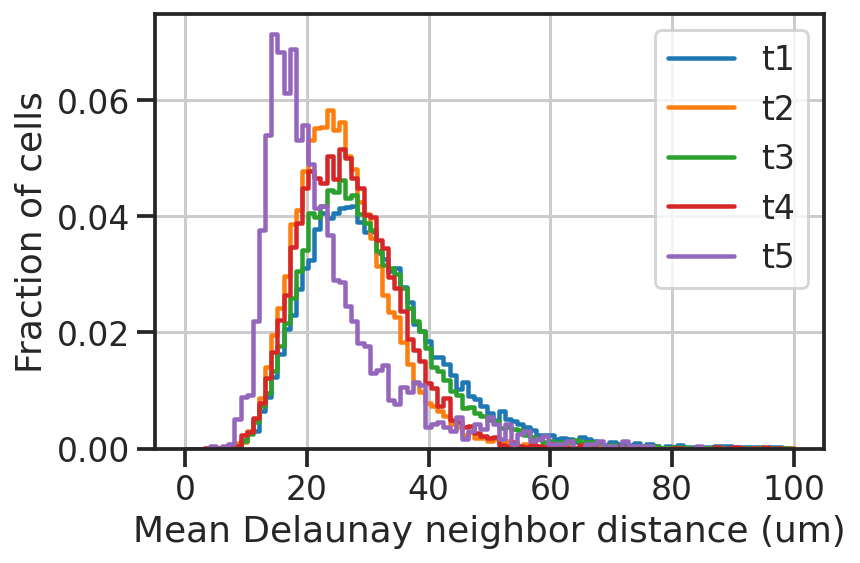

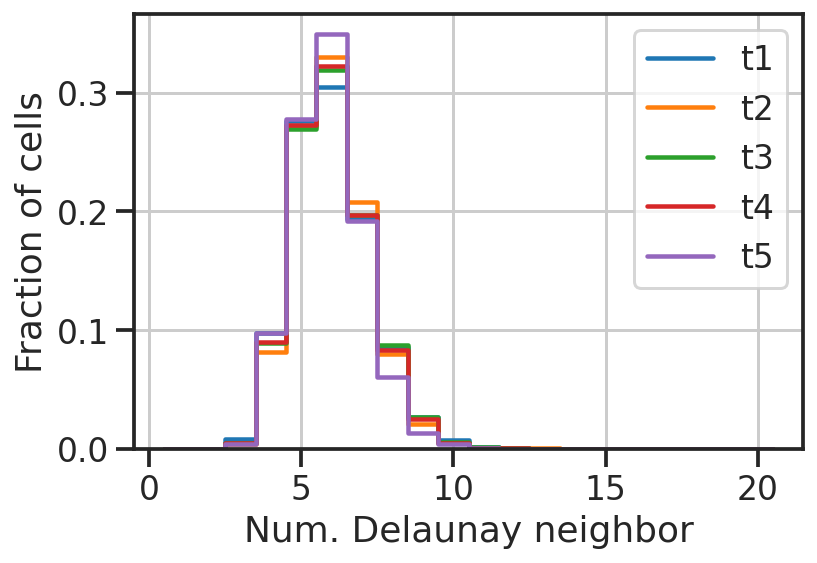

In [14]:
# by cell type
unq_types = np.unique(types)
colors = sns.color_palette("tab10", len(unq_types))
nk = np.array(layer.SG.indegree())

fig, ax = plt.subplots()
for i, t in enumerate(unq_types):
    val = meandists[types==t]
    sns.histplot(data=val, element='step', stat='probability',
                 fill=False,
                 label=t,
                 bins=np.linspace(0,100,100), 
                 color=colors[i],
                 ax=ax)
ax.legend()
ax.set_xlabel('Mean Delaunay neighbor distance (um)')
ax.set_ylabel('Fraction of cells')
plt.show()

fig, ax = plt.subplots()
for i, t in enumerate(unq_types):
    val = nk[types==t]
    sns.histplot(data=val, element='step', stat='probability',
                 fill=False,
                 label=t,
                 bins=np.arange(0.5, 21), 
                 color=colors[i],
                 ax=ax)
ax.legend()
ax.set_ylabel('Fraction of cells')
ax.set_xlabel('Num. Delaunay neighbor')
plt.show()

In [15]:
typecols = df.filter(regex='^type_|^ktype_', axis=1).columns
typecols

Index(['ktype_L1', 'ktype_L2', 'ktype_L3', 'type_r0.01', 'type_r0.02',
       'type_r0.05', 'type_r0.1', 'type_r0.2', 'type_r0.5', 'type_r1',
       'type_r2', 'type_r5', 'type_r10'],
      dtype='object')

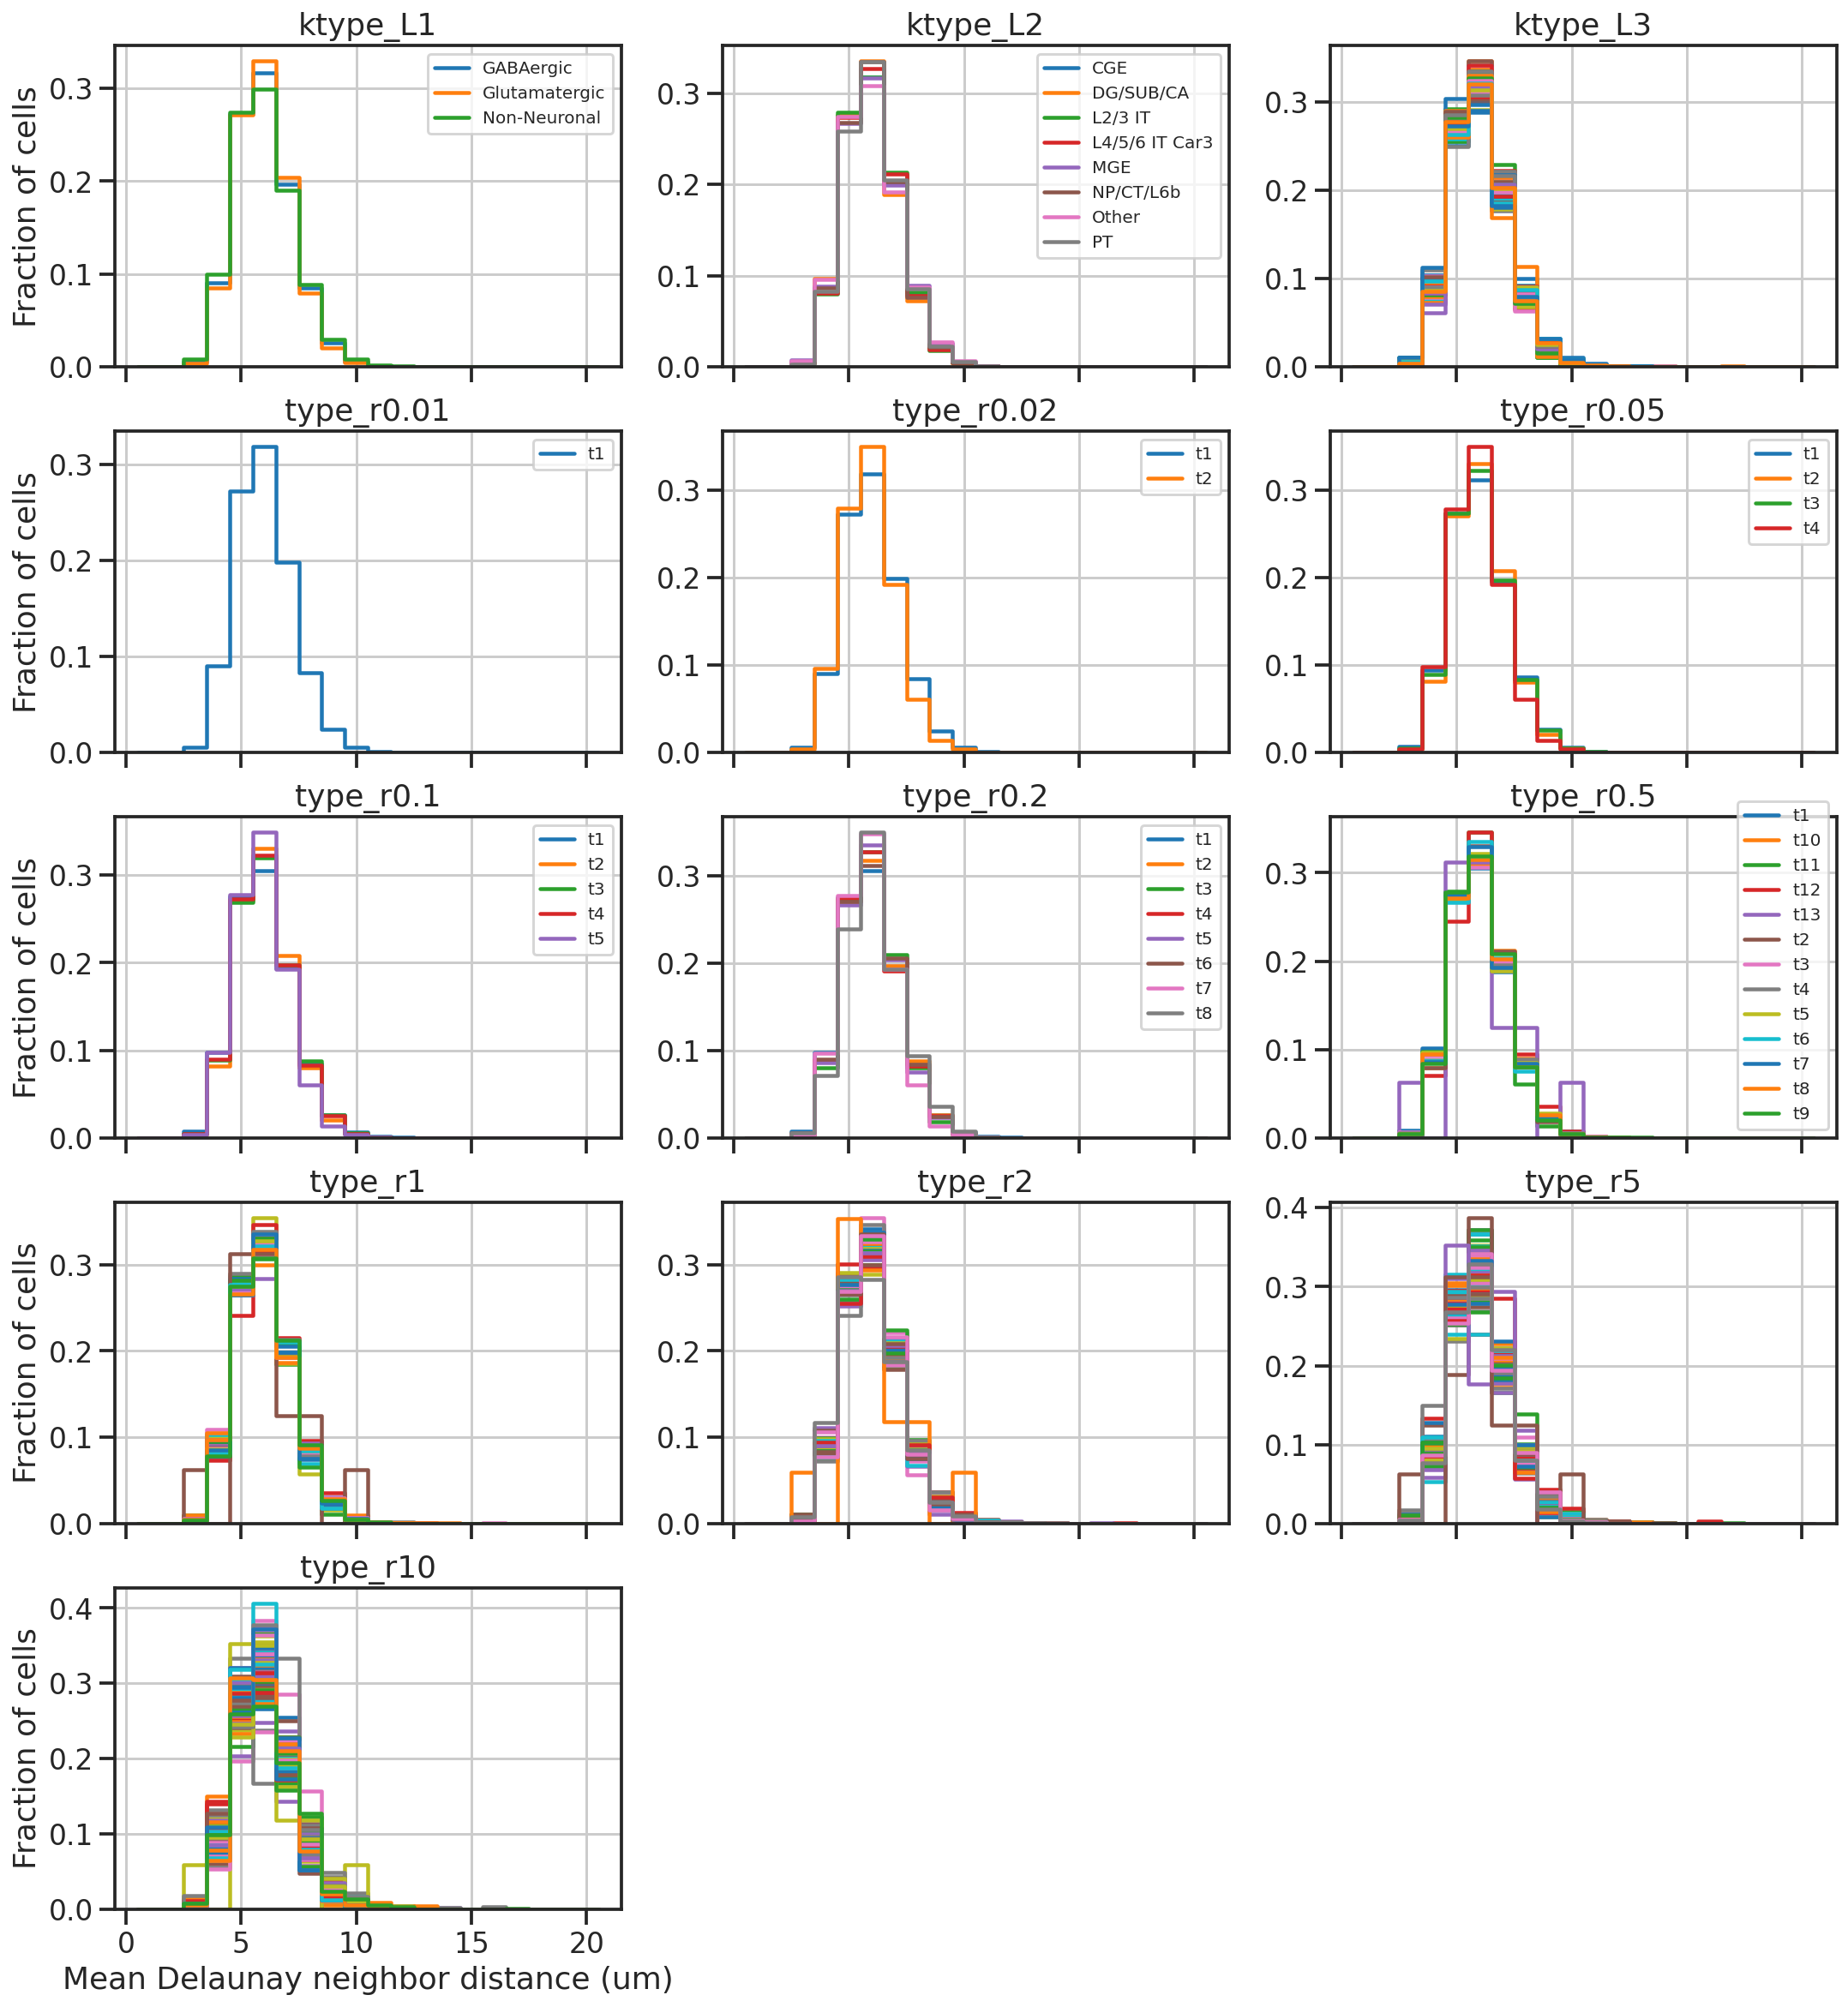

In [16]:
nk = np.array(layer.SG.indegree())

n = len(typecols)
nx = 3
ny = int((n+nx-1)/nx) 

fig, axs = plt.subplots(ny, nx, figsize=(6*nx, 4*ny), sharex=True)
for j, (typecol, ax) in enumerate(zip(typecols, axs.flat)):
    types = df[typecol].values
    # by cell type
    unq_types = np.unique(types)
    colors = sns.color_palette("tab10", len(unq_types))

    for i, t in enumerate(unq_types):
        val = nk[types==t]
        sns.histplot(data=val, element='step', stat='probability',
                     fill=False,
                     label=t,
                     bins=np.arange(0.5, 21), 
                     color=colors[i],
                     ax=ax)
    if len(unq_types) < 15:
        ax.legend(fontsize=10)
    else:
        pass
    
    ax.set_title(typecol)
    if j % nx == 0:
        ax.set_xlabel('Mean Delaunay neighbor distance (um)')
        ax.set_ylabel('Fraction of cells')
    else:
        ax.set_xlabel('')
        ax.set_ylabel('')
        
for ax in axs.flat[j+1:]:
    ax.axis('off')
plt.show()

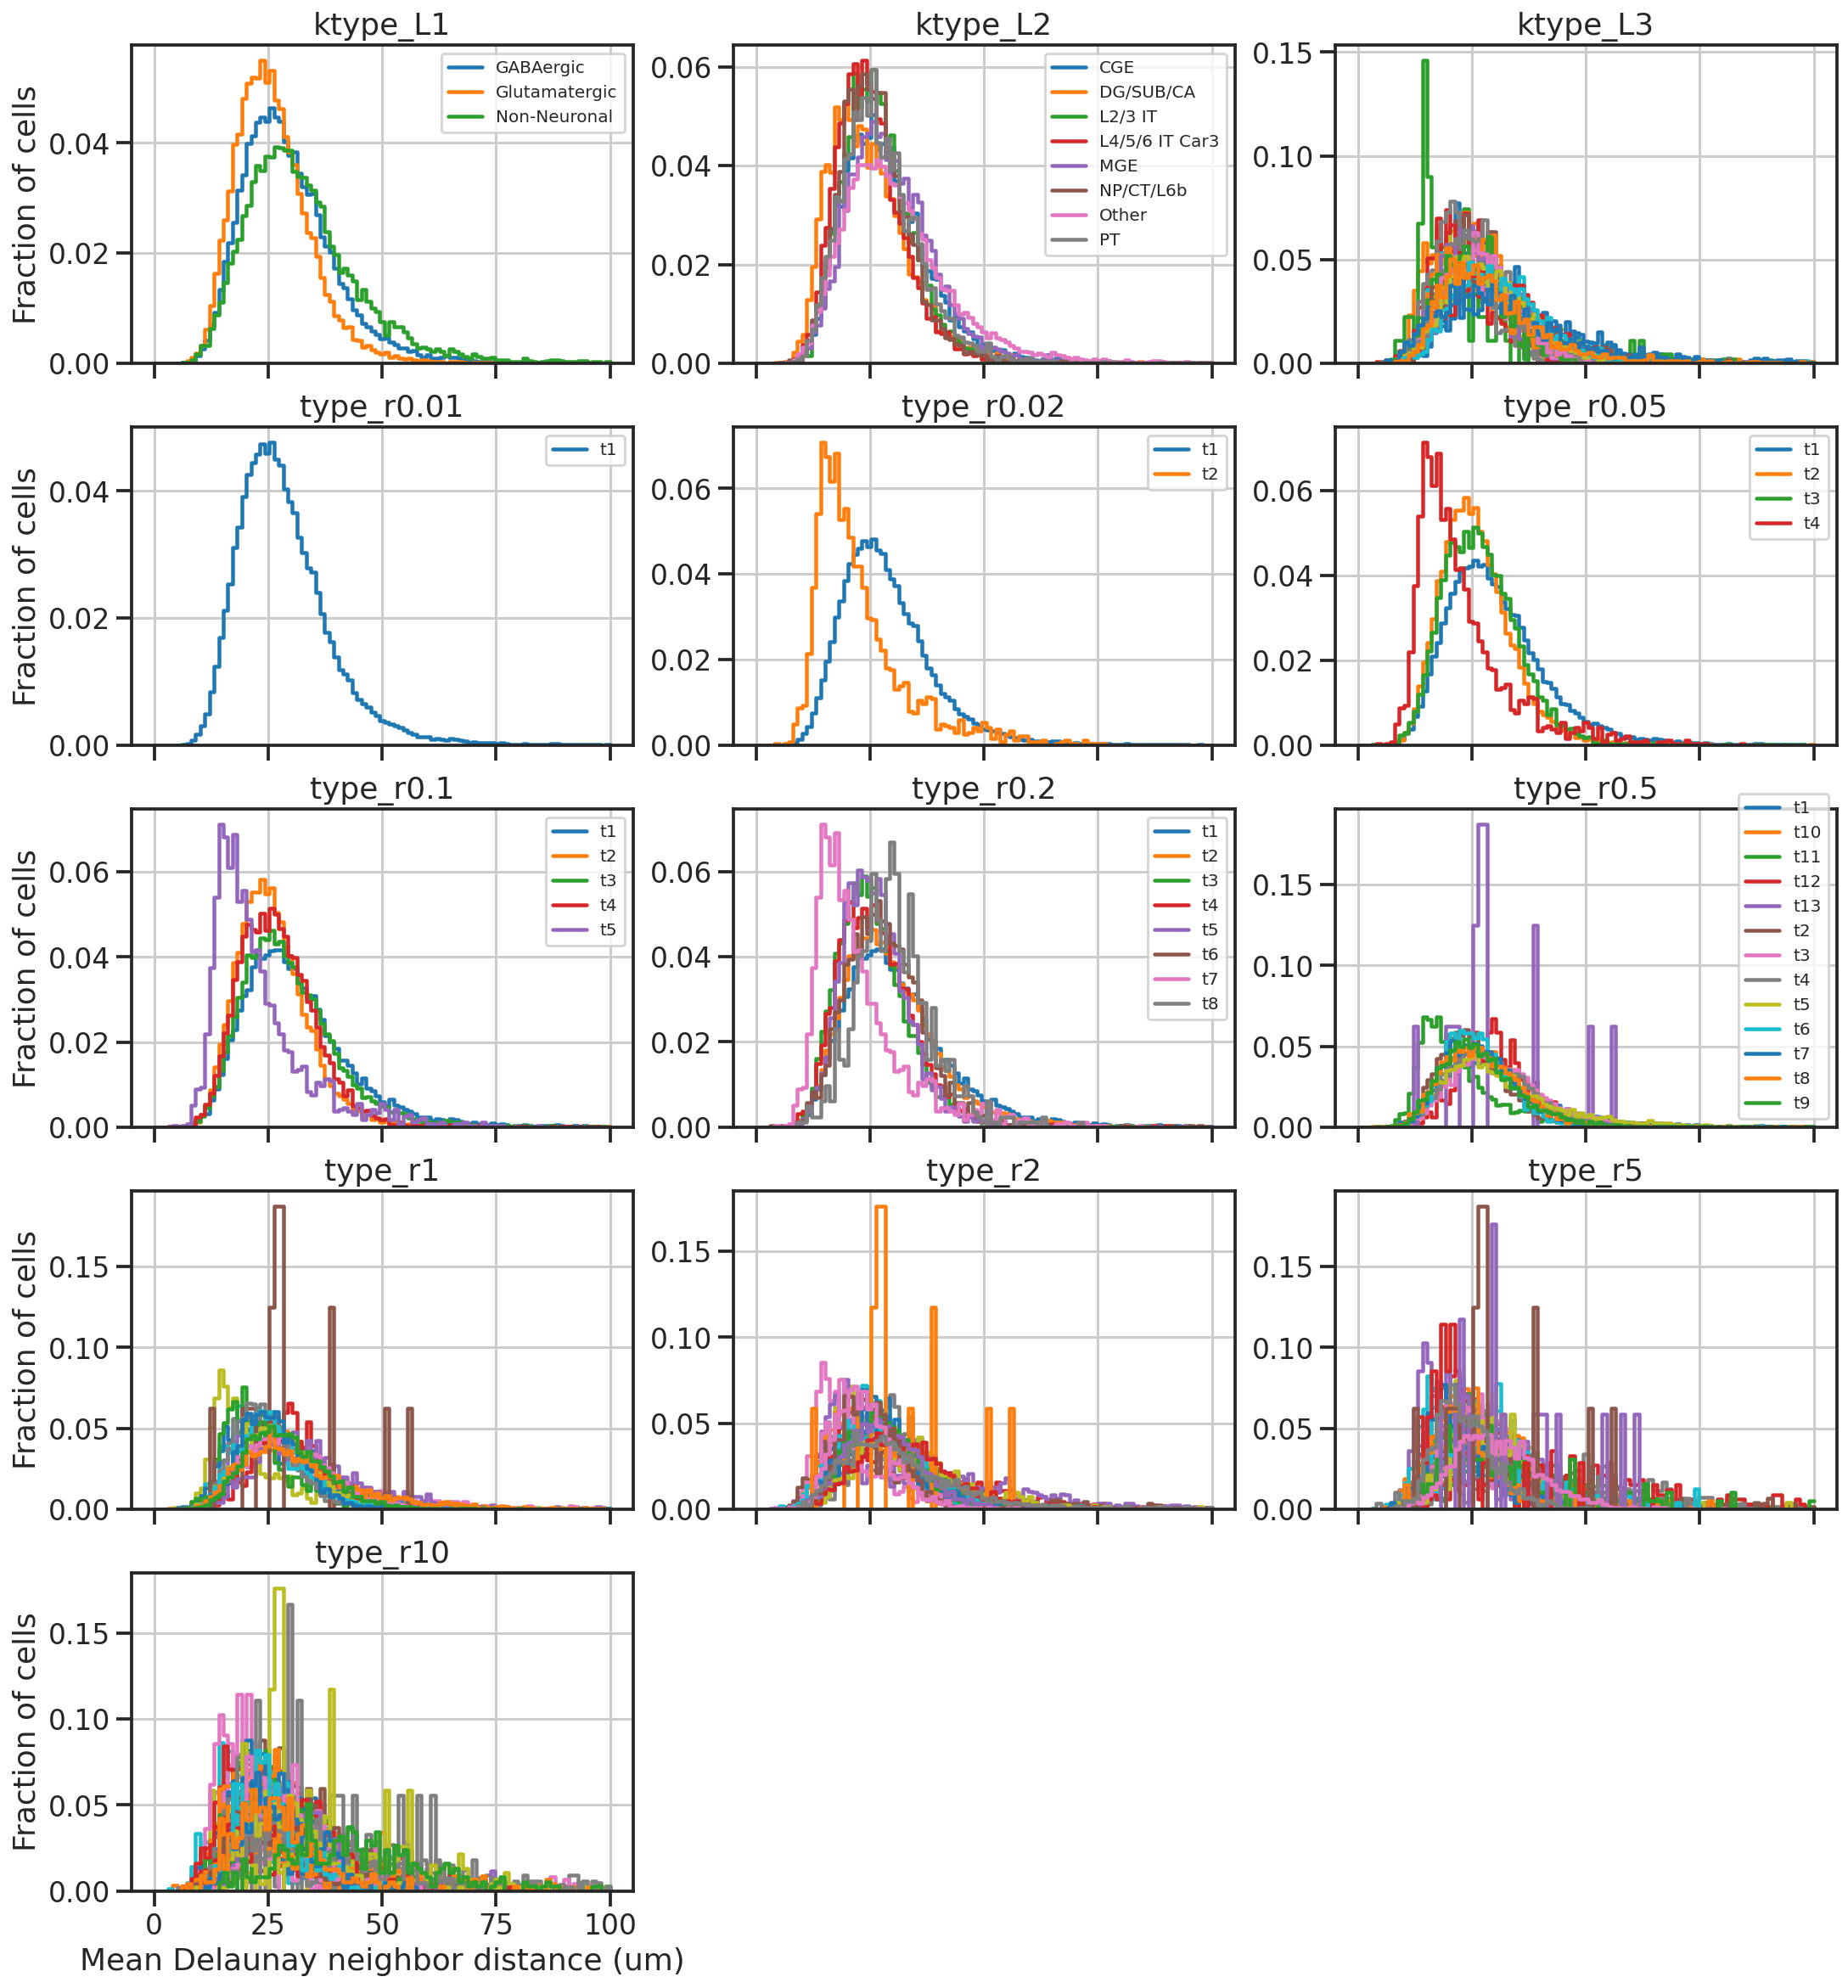

In [17]:
nk = np.array(layer.SG.indegree())

n = len(typecols)
nx = 3
ny = int((n+nx-1)/nx) 

fig, axs = plt.subplots(ny, nx, figsize=(6*nx, 4*ny), sharex=True)
for j, (typecol, ax) in enumerate(zip(typecols, axs.flat)):
    types = df[typecol].values
    # by cell type
    unq_types = np.unique(types)
    colors = sns.color_palette("tab10", len(unq_types))

    for i, t in enumerate(unq_types):
        val = meandists[types==t]
        sns.histplot(data=val, element='step', stat='probability',
                     fill=False,
                     label=t,
                     bins=np.linspace(0,100,100), 
                     color=colors[i],
                     ax=ax)
    if len(unq_types) < 15:
        ax.legend(fontsize=10)
    else:
        pass
    
    ax.set_title(typecol)
    if j % nx == 0:
        ax.set_xlabel('Mean Delaunay neighbor distance (um)')
        ax.set_ylabel('Fraction of cells')
    else:
        ax.set_xlabel('')
        ax.set_ylabel('')
        
for ax in axs.flat[j+1:]:
    ax.axis('off')
plt.show()

# Allen cell types only

In [18]:
typemap = df[['ktype_L3', 'ktype_L2']].groupby('ktype_L3').first()['ktype_L2']
typemap

ktype_L3
Astro                       Other
CA1-ProS                DG/SUB/CA
CA2-IG-FC               DG/SUB/CA
CA3                     DG/SUB/CA
CR                          Other
CT SUB                  NP/CT/L6b
Car3               L4/5/6 IT Car3
DG                      DG/SUB/CA
Endo                        Other
L2 IT ENTl                L2/3 IT
L2 IT ENTm                L2/3 IT
L2/3 IT CTX               L2/3 IT
L2/3 IT ENTl              L2/3 IT
L2/3 IT PPP               L2/3 IT
L2/3 IT RHP               L2/3 IT
L3 IT ENT                 L2/3 IT
L4 RSP-ACA                     PT
L4/5 IT CTX        L4/5/6 IT Car3
L5 IT CTX          L4/5/6 IT Car3
L5 PPP                         PT
L5 PT CTX                      PT
L5/6 IT TPE-ENT    L4/5/6 IT Car3
L5/6 NP CTX             NP/CT/L6b
L6 CT CTX               NP/CT/L6b
L6 IT CTX          L4/5/6 IT Car3
L6 IT ENTl         L4/5/6 IT Car3
L6b CTX                 NP/CT/L6b
L6b/CT ENT              NP/CT/L6b
Lamp5                         CGE
Meis2

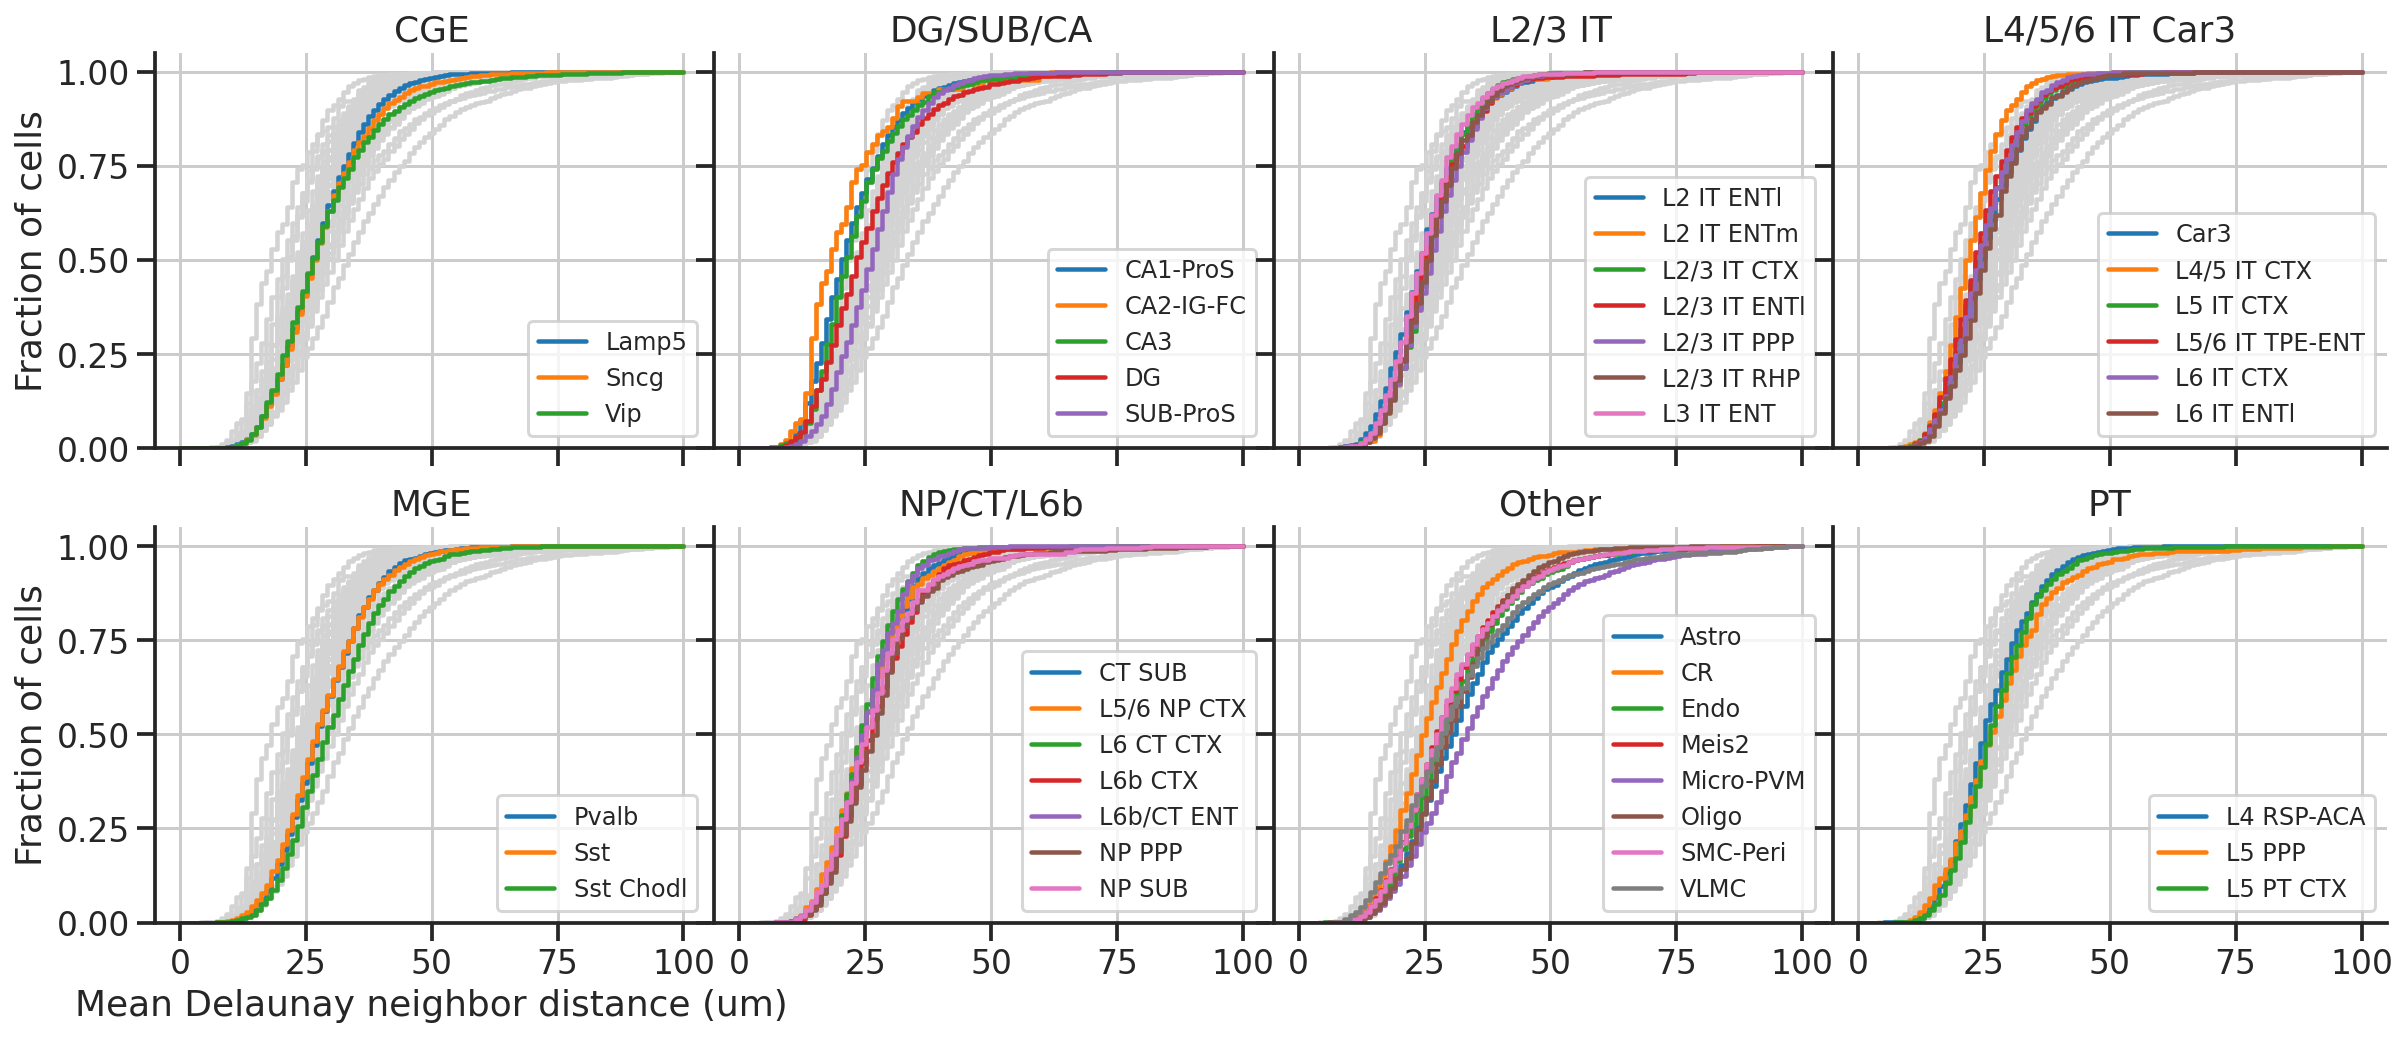

In [19]:
types = df['ktype_L3'].values
unq_types = np.sort(np.unique(types))

major_types = np.sort(np.unique(typemap))
nx = 4
ny = 2
fig, axs = plt.subplots(ny, nx, figsize=(nx*5, ny*4), sharex=True, sharey=True)
for j, major_type in enumerate(major_types):
    ax = axs.flat[j]
    minor_types = typemap[typemap==major_type].index
    ax.set_title(major_type)
    for t in unq_types:
        val = meandists[types==t]
        sns.histplot(data=val, element='step', stat='probability',
                     fill=False,
                     label='',
                     bins=np.linspace(0,100,100), 
                     color='lightgray',
                     cumulative=True,
                     ax=ax)
    for i, t in enumerate(minor_types):
        val = meandists[types==t]
        sns.histplot(data=val, element='step', stat='probability',
                     fill=False,
                     label=t,
                     bins=np.linspace(0,100,100), 
                     color=colors[i],
                     cumulative=True,
                     ax=ax)
    ax.legend(fontsize=12)
    sns.despine(ax=ax)
    if j % nx == 0:
        ax.set_xlabel('Mean Delaunay neighbor distance (um)')
        ax.set_ylabel('Fraction of cells')
    else:
        ax.set_xlabel('')
        ax.set_ylabel('')
fig.subplots_adjust(wspace=0.01)
plt.show()
        

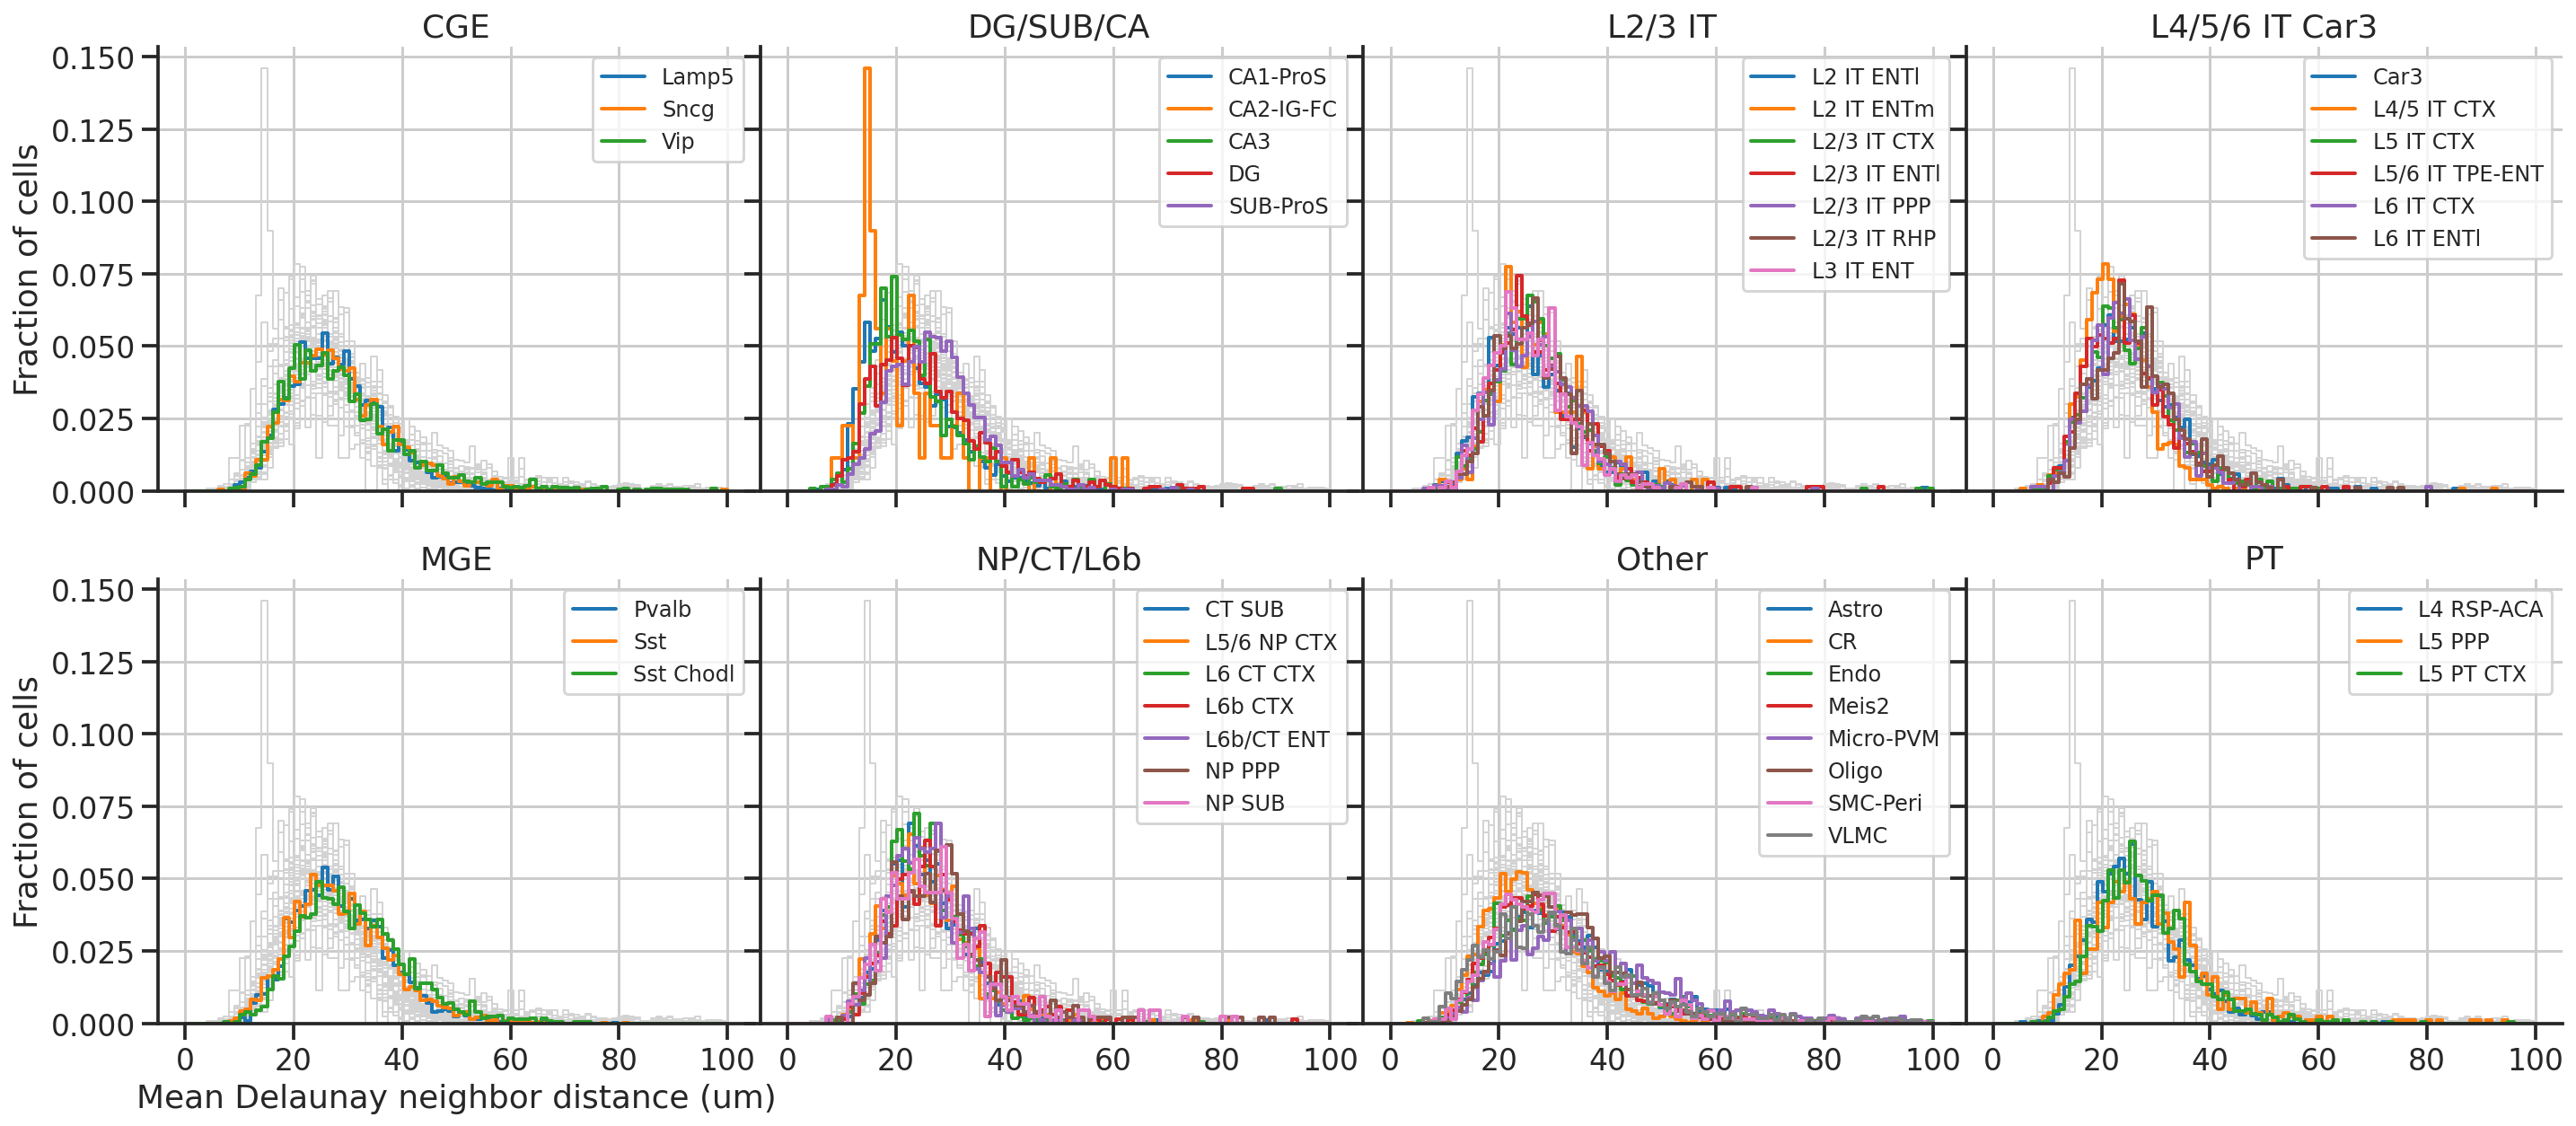

In [20]:
types = df['ktype_L3'].values
unq_types = np.sort(np.unique(types))

major_types = np.sort(np.unique(typemap))
nx = 4
ny = 2
fig, axs = plt.subplots(ny, nx, figsize=(nx*6, ny*5), sharex=True, sharey=True)
for j, major_type in enumerate(major_types):
    ax = axs.flat[j]
    minor_types = typemap[typemap==major_type].index
    ax.set_title(major_type)
    for t in unq_types:
        val = meandists[types==t]
        sns.histplot(data=val, element='step', stat='probability',
                     fill=False,
                     label='',
                     bins=np.linspace(0,100,100), 
                     color='lightgray',
                     linewidth=1,
                     # cumulative=True,
                     ax=ax)
    for i, t in enumerate(minor_types):
        val = meandists[types==t]
        sns.histplot(data=val, element='step', stat='probability',
                     fill=False,
                     label=t,
                     bins=np.linspace(0,100,100), 
                     color=colors[i],
                     linewidth=2,
                     # cumulative=True,
                     ax=ax)
    ax.legend(fontsize=12)
    sns.despine(ax=ax)
    if j % nx == 0:
        ax.set_xlabel('Mean Delaunay neighbor distance (um)')
        ax.set_ylabel('Fraction of cells')
    else:
        ax.set_xlabel('')
        ax.set_ylabel('')
fig.subplots_adjust(wspace=0.01)
plt.show()
        

# Poisson Process

$$G(w<W)=1-e^{-\lambda\pi w^2}$$

To find $\lambda$; fit CDF from data for each cell type:
$$y=1-e^{-\lambda\pi x^2}$$
$$\lambda = \frac{-\log(1-y)}{\pi x^2}$$


In [21]:
def poisson_neighbor_cdf(x, lmd=1):
    """
    """
    return 1-np.exp(-lmd*np.pi*np.power(x,2))
    

Text(0, 0.5, 'G(w)')

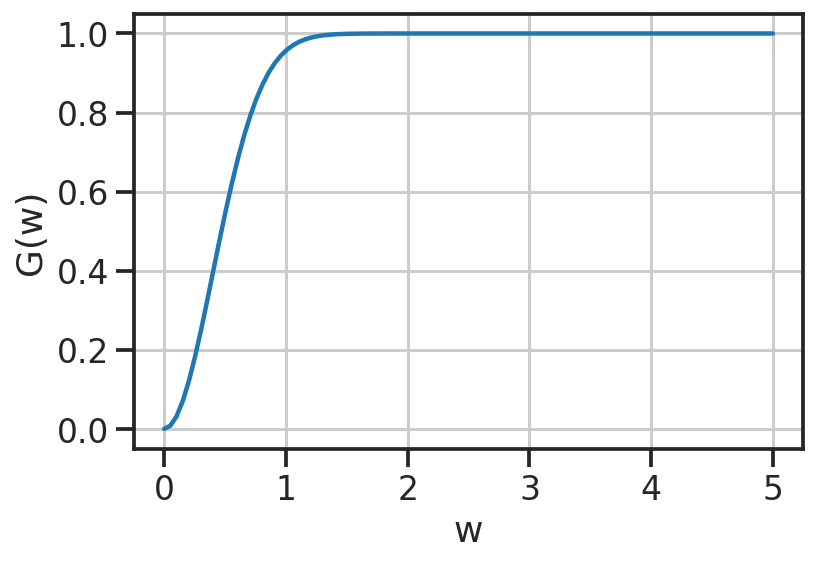

In [22]:
w = np.linspace(0,5,100)
g = poisson_neighbor_cdf(w, lmd=1)
plt.plot(w, g)
plt.xlabel('w')
plt.ylabel('G(w)')

# Mean dists

In [23]:
from sklearn.linear_model import LinearRegression

types = df['ktype_L3'].values
unq_types = np.sort(np.unique(types))
hist_dict = {}
cdf_dict = {}
lmd_hats = {}
lmdp_hats = {}
bins = np.linspace(0,100,100)
for t in unq_types:
    val = meandists[types==t]
    hist, _ = np.histogram(val, 
                 bins=bins,
                 density=True
                )
    hist_dict[t] = hist
    
    cdf = np.cumsum(hist)
    cdf_dict[t] = cdf
    
    _y = -np.log(1-cdf)
    _x = np.pi*np.power(bins[:-1], 2)
    lmd_hat = _y/np.clip(_x, 1e-10, None)
    lmd_hats[t] = lmd_hat
    
    LR = LinearRegression(fit_intercept=True)
    LR.fit(_x.reshape(-1,1), _y)
    lmdp_hats[t] = LR.coef_[0] # only 1 num
    

In [24]:
colors = sns.color_palette('tab10', n_colors=10)
colors

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

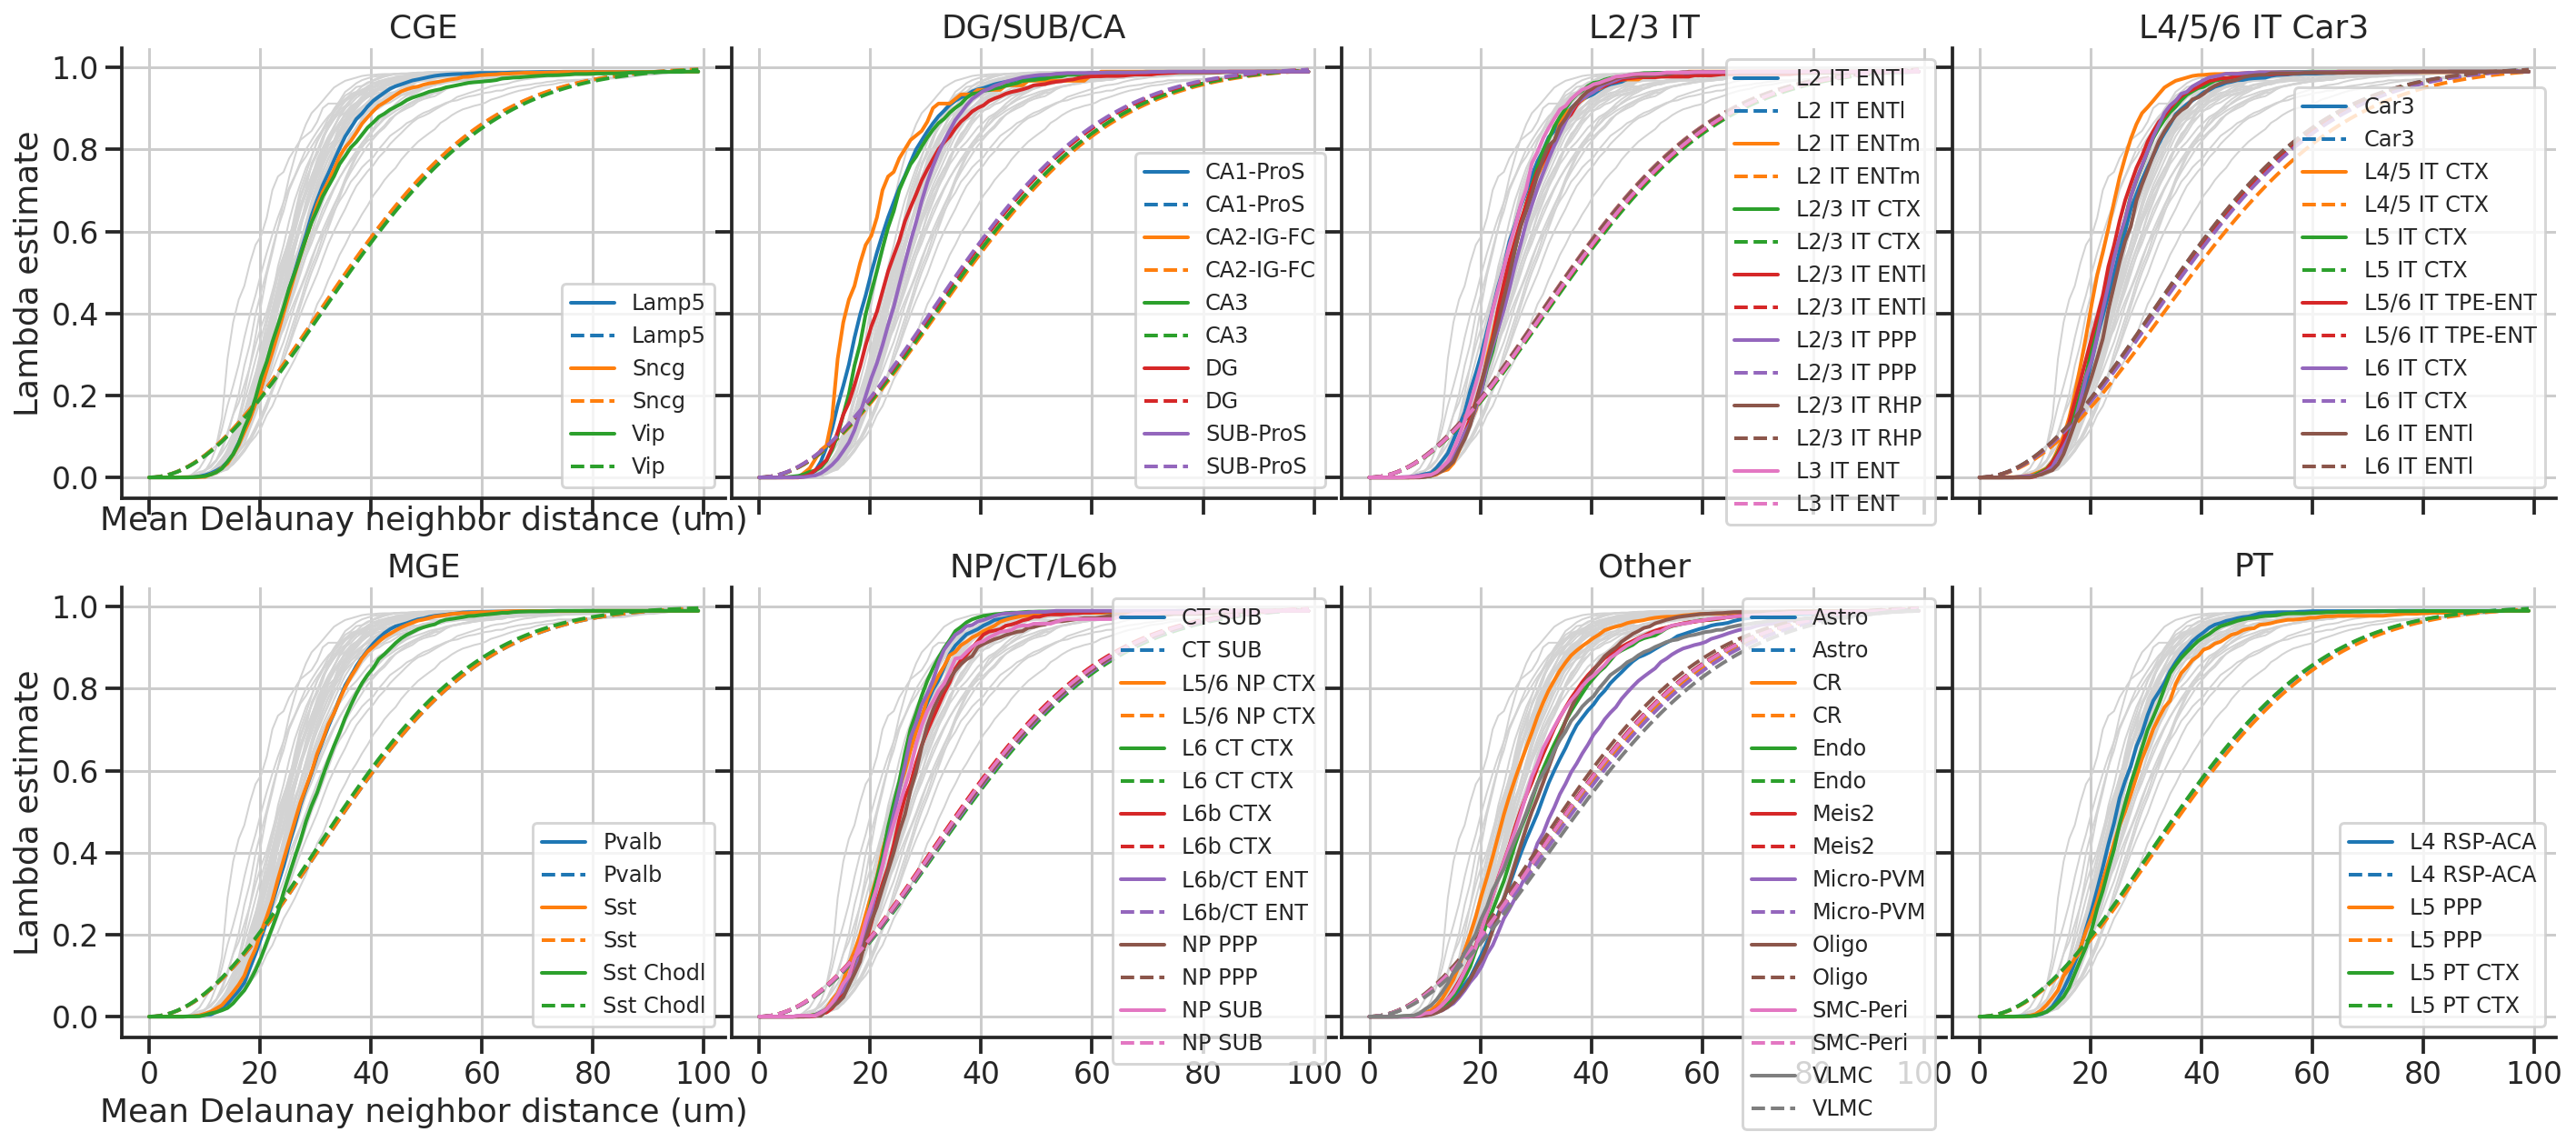

In [25]:
major_types = np.sort(np.unique(typemap))
nx = 4
ny = 2
fig, axs = plt.subplots(ny, nx, figsize=(nx*6, ny*5), sharex=True, sharey=True)
for j, major_type in enumerate(major_types):
    ax = axs.flat[j]
    minor_types = typemap[typemap==major_type].index
    ax.set_title(major_type)
    for i, t in enumerate(unq_types):
        val = cdf_dict[t] 
        lmd = lmdp_hats[t]
        ax.plot(bins[:-1], val, label='', color='lightgray', linewidth=1)
        
    for i, t in enumerate(minor_types):
        val = cdf_dict[t] 
        lmd = lmdp_hats[t]
        valfit = poisson_neighbor_cdf(bins[:-1], lmd=lmd)
        ax.plot(bins[:-1], val, label=t, linewidth=2, color=colors[i])
        ax.plot(bins[:-1], valfit, label=t, linewidth=2, linestyle='--', color=colors[i])
        
    ax.legend(fontsize=12)
    sns.despine(ax=ax)
    if j % nx == 0:
        ax.set_xlabel('Mean Delaunay neighbor distance (um)')
        ax.set_ylabel('Lambda estimate')
    else:
        ax.set_xlabel('')
        ax.set_ylabel('')
fig.subplots_adjust(wspace=0.01)
plt.show()
        

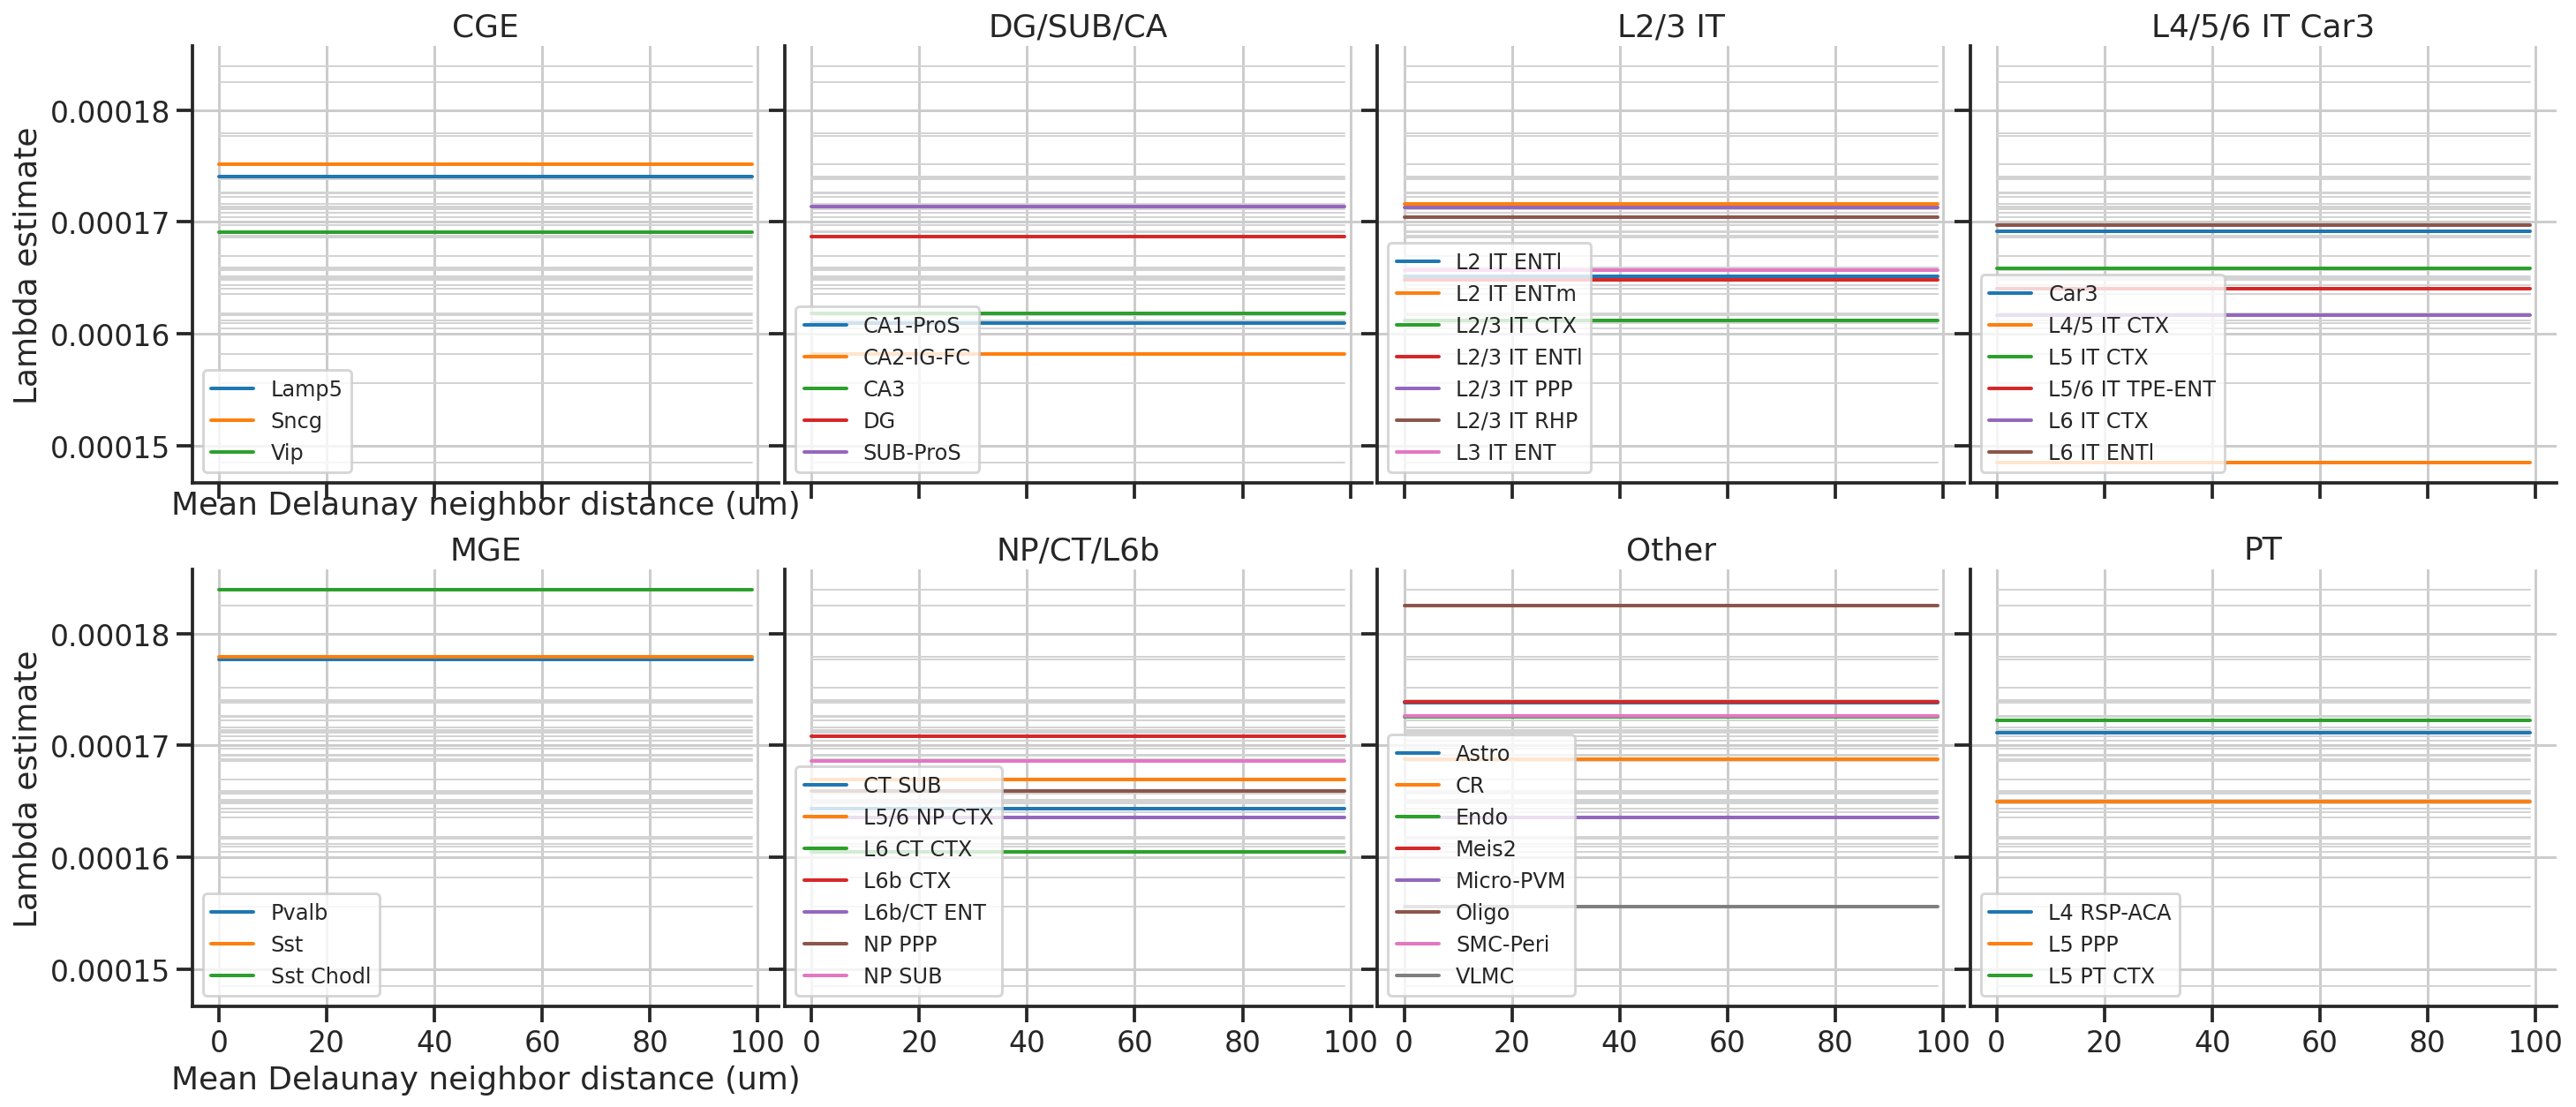

In [26]:
major_types = np.sort(np.unique(typemap))
nx = 4
ny = 2
fig, axs = plt.subplots(ny, nx, figsize=(nx*6, ny*5), sharex=True, sharey=True)
for j, major_type in enumerate(major_types):
    ax = axs.flat[j]
    minor_types = typemap[typemap==major_type].index
    ax.set_title(major_type)
    for i, t in enumerate(unq_types):
        val = lmdp_hats[t]
        val = [val]*(len(bins)-1)
        ax.plot(bins[:-1], val, label='', color='lightgray', linewidth=1)
        
    for i, t in enumerate(minor_types):
        val = lmdp_hats[t]
        val = [val]*(len(bins)-1)
        ax.plot(bins[:-1], val, label=t, linewidth=2)
        
    ax.legend(fontsize=12)
    sns.despine(ax=ax)
    if j % nx == 0:
        ax.set_xlabel('Mean Delaunay neighbor distance (um)')
        ax.set_ylabel('Lambda estimate')
    else:
        ax.set_xlabel('')
        ax.set_ylabel('')
fig.subplots_adjust(wspace=0.01)
plt.show()
        

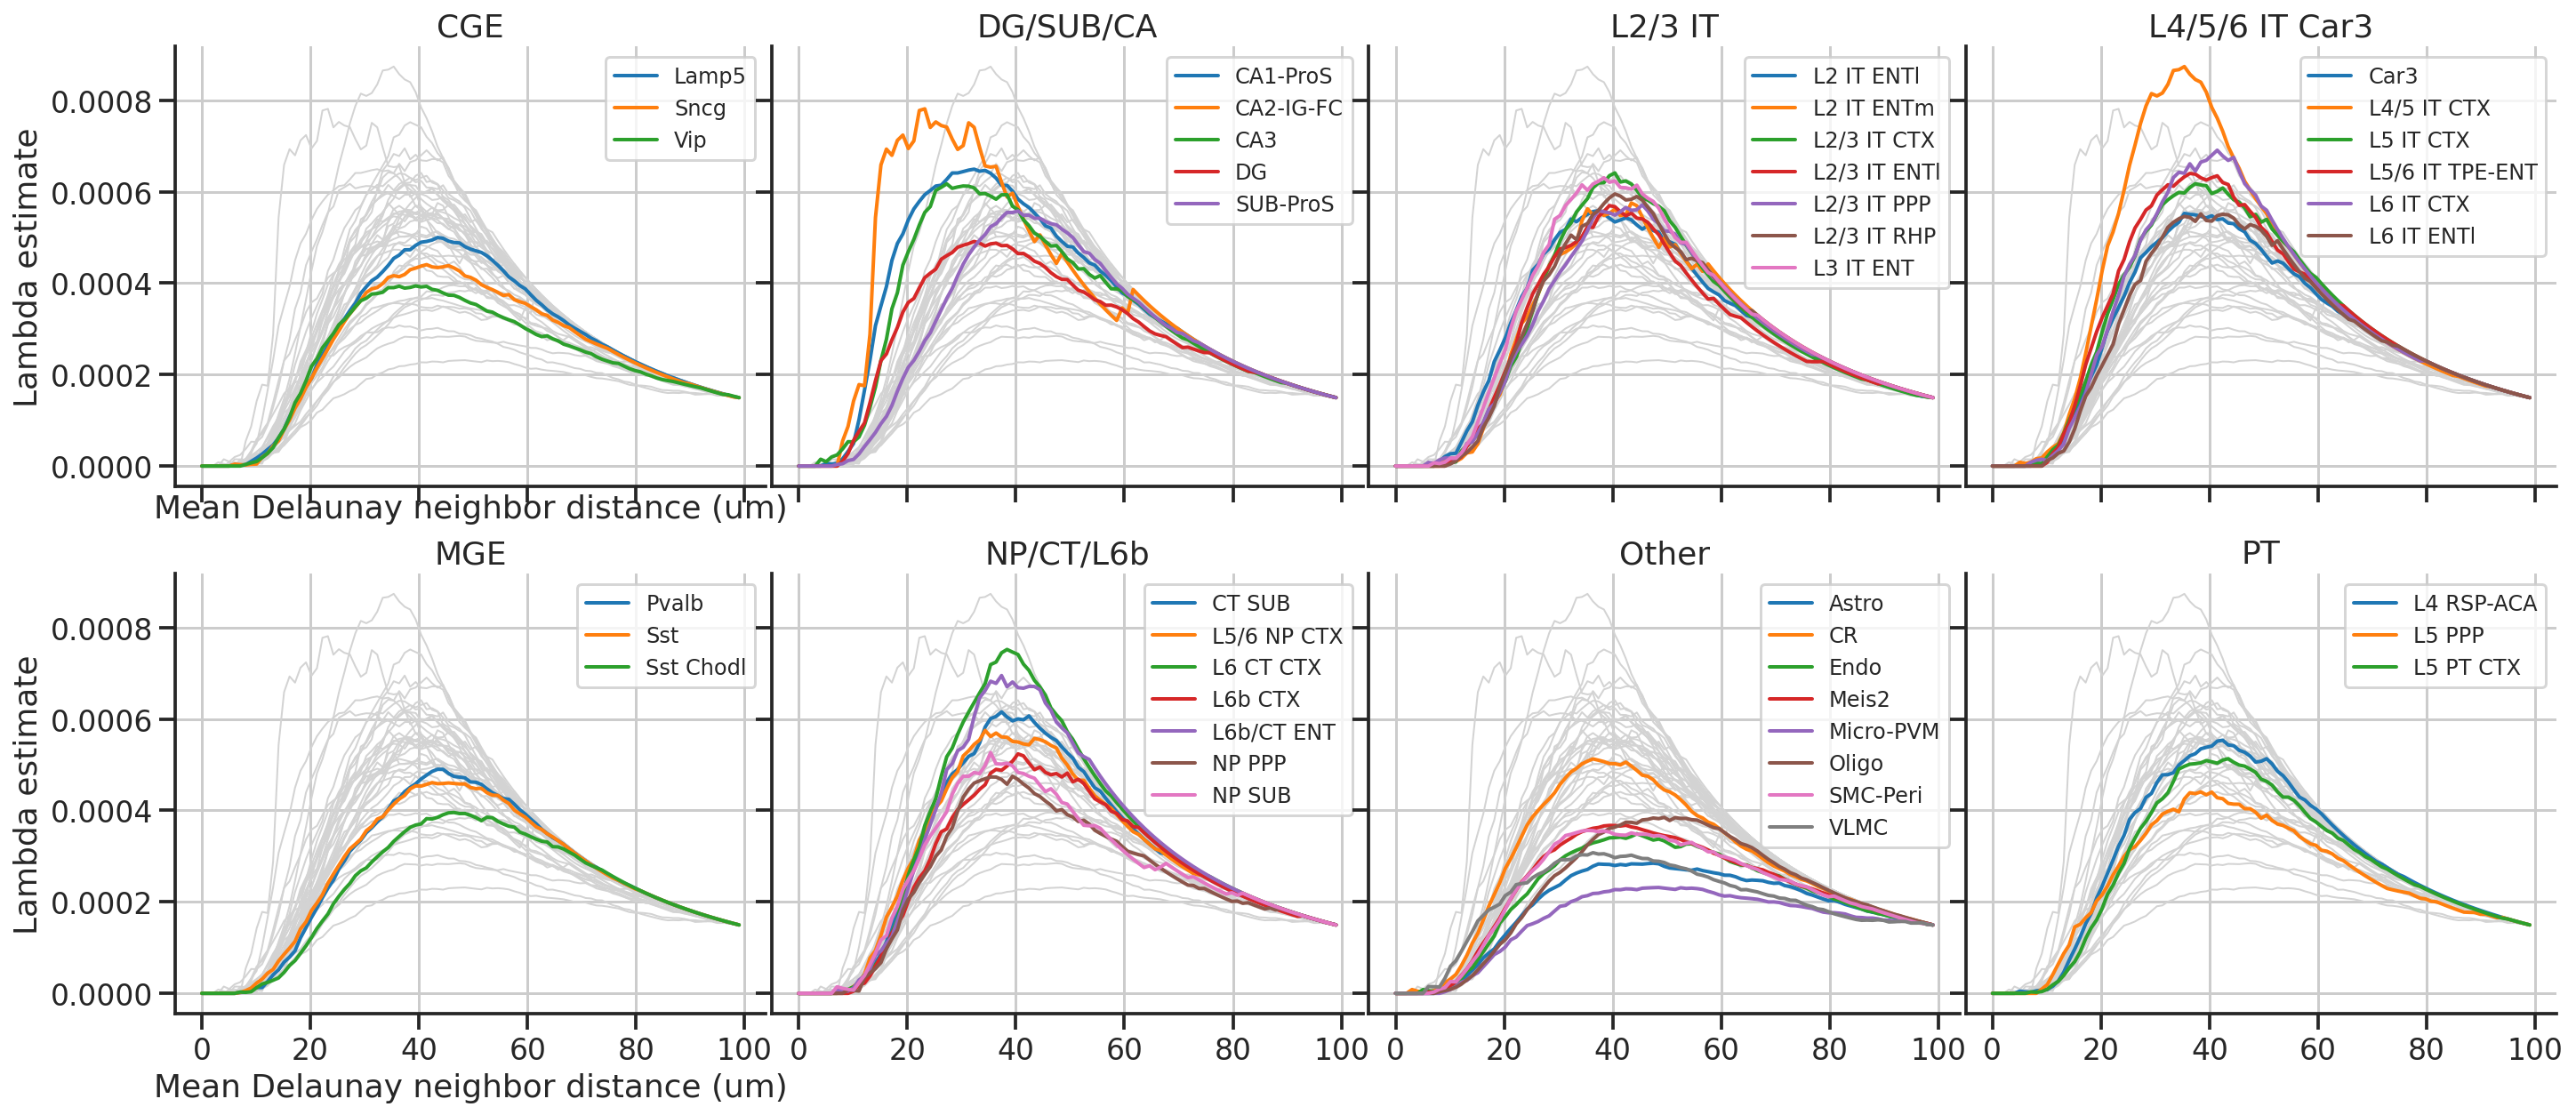

In [27]:
major_types = np.sort(np.unique(typemap))
nx = 4
ny = 2
fig, axs = plt.subplots(ny, nx, figsize=(nx*6, ny*5), sharex=True, sharey=True)
for j, major_type in enumerate(major_types):
    ax = axs.flat[j]
    minor_types = typemap[typemap==major_type].index
    ax.set_title(major_type)
    for i, t in enumerate(unq_types):
        val = lmd_hats[t]
        ax.plot(bins[:-1], val, label='', color='lightgray', linewidth=1)
        
    for i, t in enumerate(minor_types):
        val = lmd_hats[t]
        ax.plot(bins[:-1], val, label=t, linewidth=2)
        
    ax.legend(fontsize=12)
    sns.despine(ax=ax)
    if j % nx == 0:
        ax.set_xlabel('Mean Delaunay neighbor distance (um)')
        ax.set_ylabel('Lambda estimate')
    else:
        ax.set_xlabel('')
        ax.set_ylabel('')
fig.subplots_adjust(wspace=0.01)
plt.show()
        

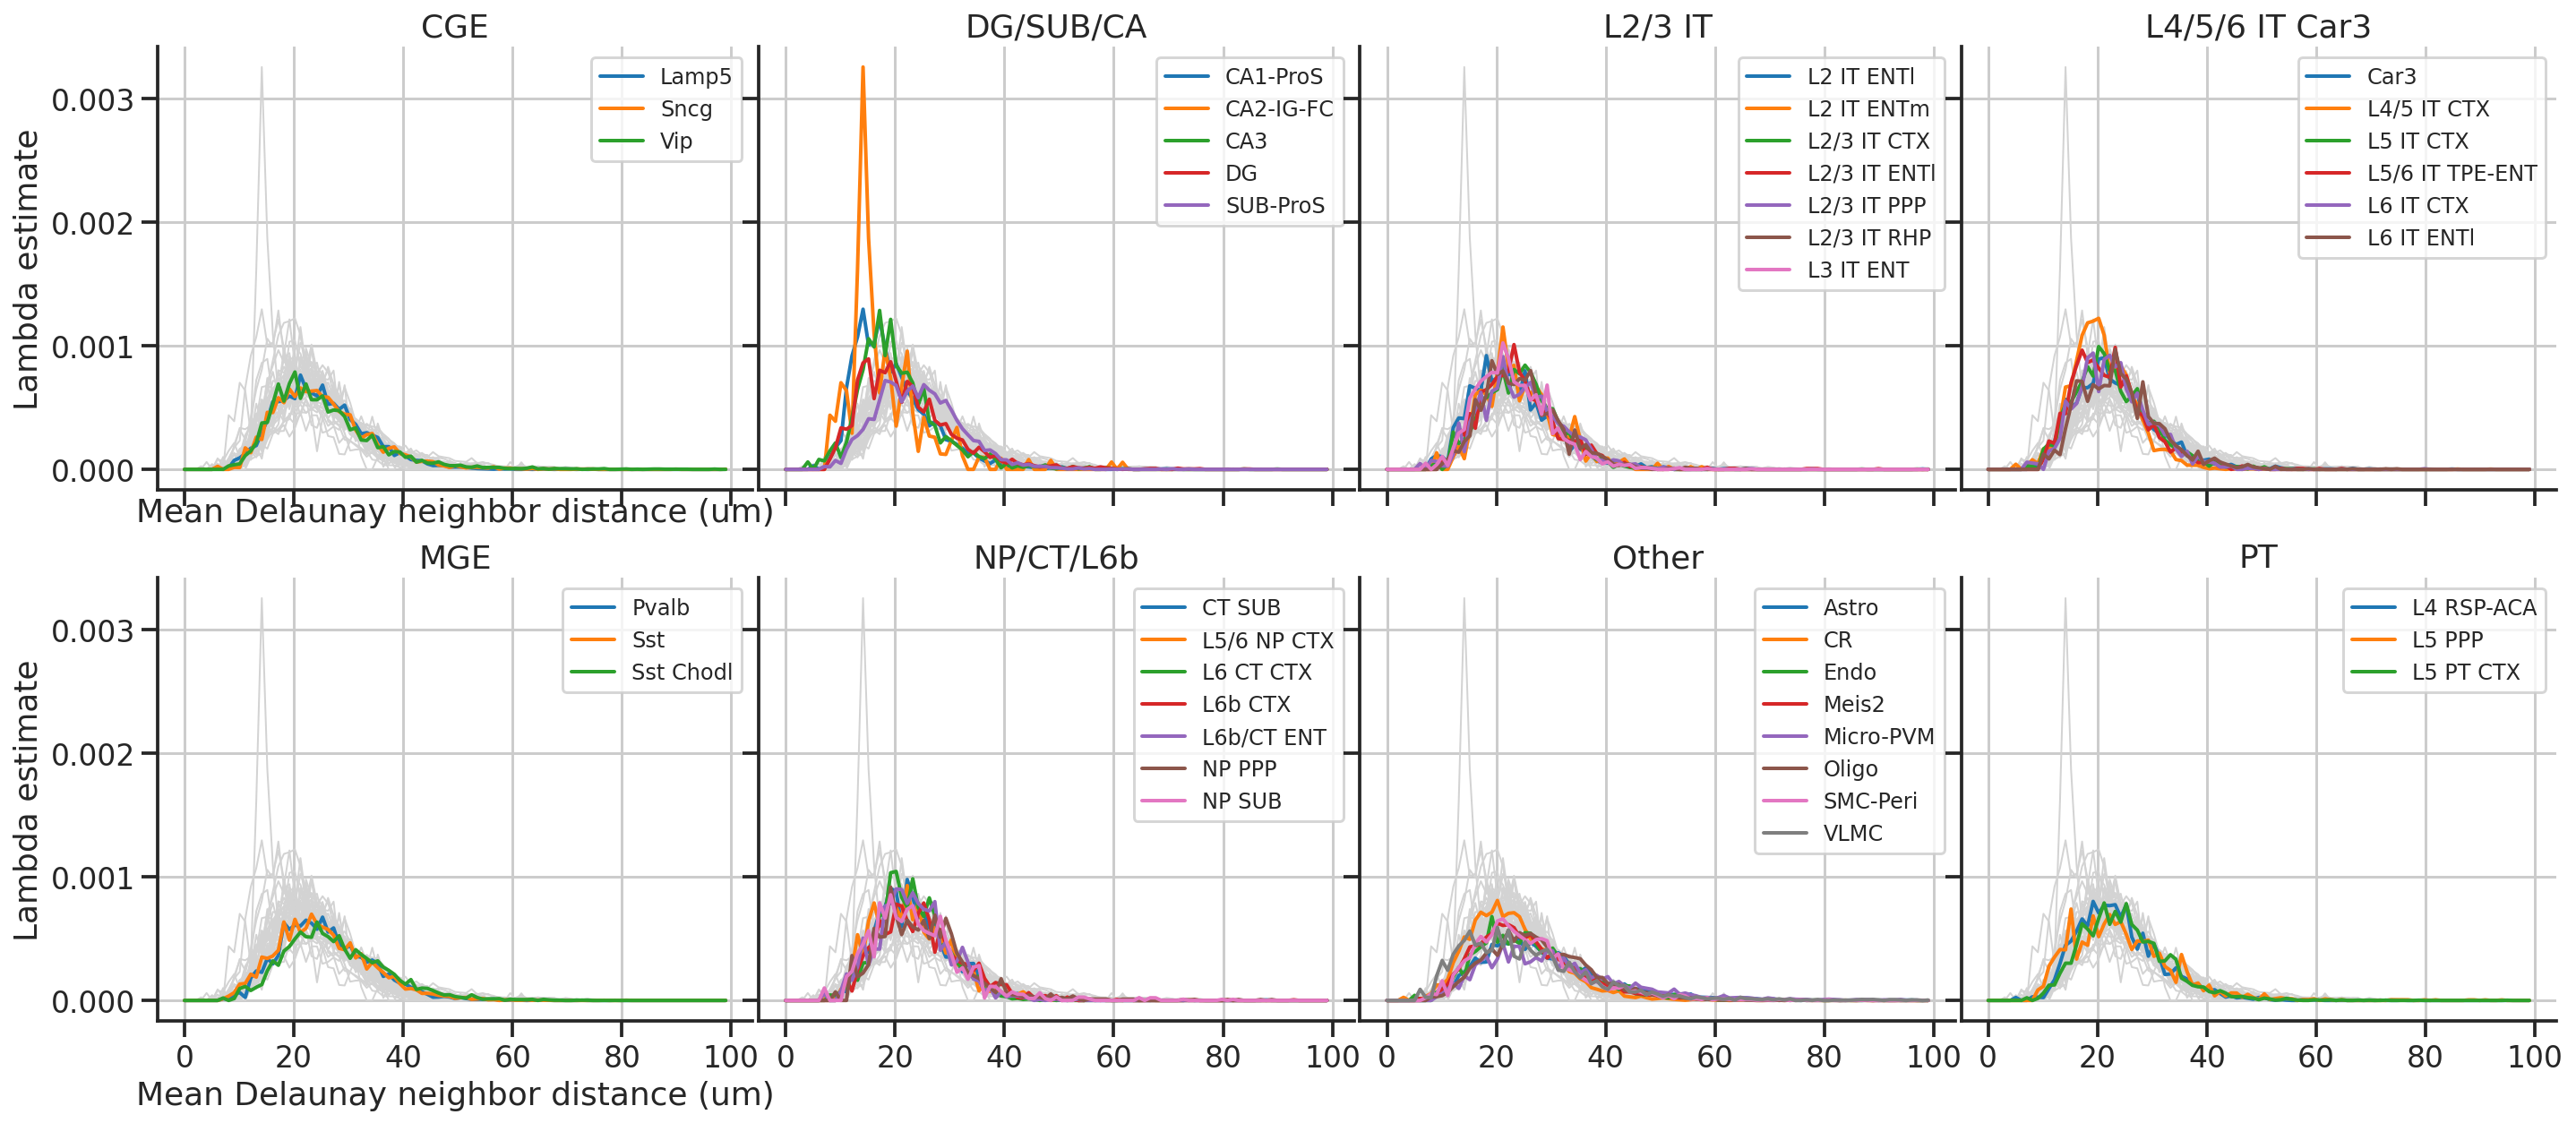

In [28]:
major_types = np.sort(np.unique(typemap))
nx = 4
ny = 2
fig, axs = plt.subplots(ny, nx, figsize=(nx*6, ny*5), sharex=True, sharey=True)
for j, major_type in enumerate(major_types):
    ax = axs.flat[j]
    minor_types = typemap[typemap==major_type].index
    ax.set_title(major_type)
    for i, t in enumerate(unq_types):
        val = hist_dict[t]
        val = val/np.clip((np.pi*bins[:-1]), 1e-10, None)
        ax.plot(bins[:-1], val, label='', color='lightgray', linewidth=1)
        
    for i, t in enumerate(minor_types):
        val = hist_dict[t]
        val = val/np.clip((np.pi*bins[:-1]), 1e-10, None)
        ax.plot(bins[:-1], val, label=t, linewidth=2)
        
    ax.legend(fontsize=12)
    sns.despine(ax=ax)
    if j % nx == 0:
        ax.set_xlabel('Mean Delaunay neighbor distance (um)')
        ax.set_ylabel('Lambda estimate')
    else:
        ax.set_xlabel('')
        ax.set_ylabel('')
fig.subplots_adjust(wspace=0.01)
plt.show()
        